Zach's EDA Jupyter Notebook
TODO:
-Add GEOID to all tables

Access database, find all tables

In [1]:
import pandas as pd
import numpy as np
import oracledb
import logging
from geopy.geocoders import Nominatim
from pathlib import Path
from numba import njit
from pathlib import Path
from IPython import get_ipython
current_file = Path(get_ipython().run_line_magic('pwd', '')).resolve()


#Connect to database
password = 'aybM6CFL9gykHEKn'
wallet_password = 'phbUHx6CMjxQj75A'

connect:str = input("Connect to the database y/n: \n")
if connect.lower() == 'y':
    connection = oracledb.connect(
        user="admin",
        password=password,
        dsn = "ltl3y0m4d7of29l1_high",
        config_dir=(str(current_file.parent / 'config')),
        wallet_location=(str(current_file.parent / 'config')),
        wallet_password=wallet_password)

    logging.info("Successfully connected to Oracle Database")
    cursor = connection.cursor()
else:
    print("Didn't connect to the database")

In [2]:
cursor.execute("SELECT table_name FROM user_tables")
table_names = [row[0] for row in cursor.fetchall()]
print(f"Tables in the database: {table_names}")

Tables in the database: ['CENSUS', 'HISTORIC_REAL_ESTATE', 'CALLS', 'TEST_TABLE', 'HISTORIC_CRIME', 'CALLS_DUP', 'CRIME', 'SDW$ERR$_CRIME']


Calls section

In [3]:
import pandas as pd
calls = pd.read_sql("Select * from Calls", connection)
#calls.fillna(0,inplace = True)
calls.head()

C:\Users\zfara\AppData\Local\Temp\ipykernel_19984\480166161.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  calls = pd.read_sql("Select * from Calls", connection)


,CALL_NUMBER,DATE_TIME,LOCATION,POLICE_DISTRICT,NATURE_OF_CALL,STATUS,LATITUDE,LONGITUDE,GEOID
0,230440688,02/13/2023 01:57:37 PM,"2715 S 28TH ST,MKE",2,ENTRY,Service in Progress,42.995394,-87.949719,55079018900
1,230440614,02/13/2023 01:51:36 PM,5909 N MILWAUKEE RIVER PARKWAY,1,PRISONER TRANS,Service in Progress,43.125401,-87.929881,55079060200
2,230440672,02/13/2023 01:43:47 PM,"4224 W JUNEAU AV,MKE",3,CALL FOR POLICE,Advised,43.046080,-87.967901,55079012400
3,230440674,02/13/2023 01:42:36 PM,"245 W LINCOLN AV,MKE",2,RETURN STATION,Assignment Completed,43.002518,-87.913685,55079186600
4,230440657,02/13/2023 01:41:19 PM,"2460 N 9TH ST,MKE",3,THEFT VEHICLE,Unable to Locate Complainant,43.063239,-87.922582,55079185500


In [4]:
calls.NATURE_OF_CALL.value_counts()[:10]

RETURN STATION     3270
TRAFFIC STOP       2833
TRBL W/SUBJ        2729
BUSINESS CHECK     2532
WELFARE CITIZEN    2146
SPECIAL ASSIGN     1885
PATROL             1816
FOLLOW UP          1813
SHOTSPOTTER        1495
ACC PDO            1418
Name: NATURE_OF_CALL, dtype: int64

In [4]:
from datetime import datetime
datetime.strptime(calls.DATE_TIME[0], '%m/%d/%Y %I:%M:%S %p')
calls['datetime_column'] = calls.DATE_TIME.apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))
calls['Hour'] = calls.datetime_column.apply(lambda x: x.hour)
calls['DayOfWeek'] = calls.datetime_column.apply(lambda x: x.weekday())

<AxesSubplot: xlabel='datetime_column', ylabel='Count'>

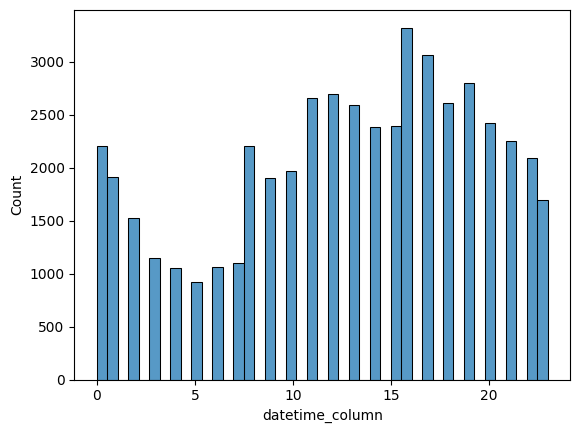

In [6]:
import seaborn as sns 
sns.histplot(calls.datetime_column.apply(lambda x: x.hour))

In [5]:
import matplotlib.pyplot as plt
top_10_natures = calls.NATURE_OF_CALL.value_counts()[0:10].index
#t10_natures_df = calls.NATURE_OF_CALL[calls.NATURE_OF_CALL.isin(top_10_natures)]
#sns.histplot(t10_natures_df)
## Disable the x-axis
#plt.setp(plt.gca().get_xticklabels(), visible=False);
print(top_10_natures)

Index(['RETURN STATION', 'TRBL W/SUBJ', 'TRAFFIC STOP', 'BUSINESS CHECK',
       'WELFARE CITIZEN', 'SPECIAL ASSIGN', 'FOLLOW UP', 'PATROL',
       'SHOTSPOTTER', 'ACC PDO'],
      dtype='object')


In [6]:
pivot = pd.DataFrame(columns= ['DayOfWeek','Hour','GEOID','NumPatrols','NumCalls'])

arr = calls.GEOID.unique()
#for ID in calls.GEOID.unique():

GEOIDs = np.apply_along_axis(lambda x: np.repeat(x,24*7),0,arr)
dayOfWeek = [0,1,2,3,4,5,6] *24*len(arr)
hour = list(range(24))*7*len(arr)

pivot['DayOfWeek'] = dayOfWeek
pivot['GEOID'] = GEOIDs
pivot['Hour'] = hour
pivot.fillna(0,inplace=True)
pivot['NumCalls'] = [0]*24*7*len(arr)
pivot['NumPatrols'] = [0]*24*7*len(arr)

In [7]:
#Get num patrol
def get_num_patrols(row):
    hour = row['Hour']
    dayOfWeek = row['DayOfWeek']
    GEOID = row['GEOID']
    if row.NATURE_OF_CALL == 'PATROL':
        pivot.loc[(pivot['DayOfWeek'] == dayOfWeek) & (pivot['Hour'] == hour) & (pivot['GEOID'] == GEOID),'NumPatrols']+=1
    else:
        pivot.loc[(pivot['DayOfWeek'] == dayOfWeek) & (pivot['Hour'] == hour) & (pivot['GEOID'] == GEOID),'NumCalls']+= 1

calls.apply(lambda row: get_num_patrols(row),axis = 1);

In [10]:
merged_df = pd.merge(pivot,census,on = 'GEOID')

In [11]:
merged_df

,DayOfWeek,Hour,GEOID,NumPatrols,NumCalls,ESTIMATED_POP,MALE_POP,FEMALE_POP,MEDIAN_AGE,MEDIAN_INCOME,WHITE_POP,BLACK_POP,NATIVE_POP,HISPANIC_POP,INCOME_POV_LVL
0,0,0,55079018900,0,0,1576.0,773.0,803.0,36.9,27478.0,927.0,100.0,0.0,1576.0,1576.0
1,1,1,55079018900,0,0,1576.0,773.0,803.0,36.9,27478.0,927.0,100.0,0.0,1576.0,1576.0
2,2,2,55079018900,0,1,1576.0,773.0,803.0,36.9,27478.0,927.0,100.0,0.0,1576.0,1576.0
3,3,3,55079018900,0,0,1576.0,773.0,803.0,36.9,27478.0,927.0,100.0,0.0,1576.0,1576.0
4,4,4,55079018900,0,2,1576.0,773.0,803.0,36.9,27478.0,927.0,100.0,0.0,1576.0,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43003,2,19,55079101600,0,0,3967.0,1718.0,2249.0,41.4,34524.0,3760.0,82.0,0.0,3967.0,3870.0
43004,3,20,55079101600,0,0,3967.0,1718.0,2249.0,41.4,34524.0,3760.0,82.0,0.0,3967.0,3870.0
43005,4,21,55079101600,0,0,3967.0,1718.0,2249.0,41.4,34524.0,3760.0,82.0,0.0,3967.0,3870.0
43006,5,22,55079101600,0,0,3967.0,1718.0,2249.0,41.4,34524.0,3760.0,82.0,0.0,3967.0,3870.0


In [22]:
x_train.to_numpy().astype(np.float)

C:\Users\zfara\AppData\Local\Temp\ipykernel_19984\3780038897.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train.to_numpy().astype(np.float)


array([[0.00000000e+00, 0.00000000e+00, 5.50790189e+10, ...,
        0.00000000e+00, 1.57600000e+03, 1.57600000e+03],
       [1.00000000e+00, 1.00000000e+00, 5.50790189e+10, ...,
        0.00000000e+00, 1.57600000e+03, 1.57600000e+03],
       [2.00000000e+00, 2.00000000e+00, 5.50790189e+10, ...,
        0.00000000e+00, 1.57600000e+03, 1.57600000e+03],
       ...,
       [4.00000000e+00, 2.10000000e+01, 5.50791016e+10, ...,
        0.00000000e+00, 3.96700000e+03, 3.87000000e+03],
       [5.00000000e+00, 2.20000000e+01, 5.50791016e+10, ...,
        0.00000000e+00, 3.96700000e+03, 3.87000000e+03],
       [6.00000000e+00, 2.30000000e+01, 5.50791016e+10, ...,
        0.00000000e+00, 3.96700000e+03, 3.87000000e+03]])

In [54]:
import torch
x_train = merged_df.drop(['NumPatrols'],axis = 1)
y_train = merged_df['NumPatrols']

x_train = torch.tensor(x_train.to_numpy().astype(np.float)).float()
y_train = torch.tensor(y_train.to_numpy()).float()

C:\Users\zfara\AppData\Local\Temp\ipykernel_19984\181482463.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = torch.tensor(x_train.to_numpy().astype(np.float)).float()


In [84]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14, 512),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [90]:
net = NeuralNetwork()
net(x_train[0:10])

tensor([[-1.7075e+09],
        [ 2.4266e+09],
        [ 9.9412e+09],
        [ 3.5394e+09],
        [ 3.9262e+09],
        [ 2.9009e+09],
        [ 2.5034e+09],
        [ 9.7249e+08],
        [ 8.9779e+08],
        [ 8.7107e+09]], grad_fn=<AddmmBackward0>)

In [91]:
import torch.optim as optim

learning_rate = .0001
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(),learning_rate)
batch_size = 32


for epoch in range(100):
    print(epoch)
    print(loss)
    for i in range(0,len(x_train),batch_size):
        inputs = x_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, labels)
        loss.backward()
        optimizer.step()


0
tensor(24286916., grad_fn=<MseLossBackward0>)


c:\Users\zfara\Documents\Files\Code\python_envs\3.9general\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1
tensor(7.7946e+17, grad_fn=<MseLossBackward0>)
2
tensor(1.1726e+17, grad_fn=<MseLossBackward0>)
3
tensor(3.3485e+16, grad_fn=<MseLossBackward0>)
4
tensor(3.1471e+15, grad_fn=<MseLossBackward0>)
5
tensor(1.2078e+14, grad_fn=<MseLossBackward0>)
6
tensor(2.1365e+13, grad_fn=<MseLossBackward0>)
7
tensor(6.0291e+12, grad_fn=<MseLossBackward0>)
8
tensor(6.8783e+11, grad_fn=<MseLossBackward0>)
9
tensor(9.8669e+13, grad_fn=<MseLossBackward0>)
10
tensor(2.0263e+12, grad_fn=<MseLossBackward0>)
11
tensor(2.0543e+12, grad_fn=<MseLossBackward0>)
12
tensor(3.6757e+13, grad_fn=<MseLossBackward0>)
13
tensor(2.4092e+11, grad_fn=<MseLossBackward0>)
14
tensor(3.3926e+13, grad_fn=<MseLossBackward0>)
15
tensor(4.4321e+13, grad_fn=<MseLossBackward0>)
16
tensor(1.6879e+13, grad_fn=<MseLossBackward0>)
17
tensor(1.0729e+12, grad_fn=<MseLossBackward0>)
18
tensor(5.3390e+11, grad_fn=<MseLossBackward0>)
19
tensor(2.7855e+14, grad_fn=<MseLossBackward0>)
20
tensor(2.8330e+13, grad_fn=<MseLossBackward0>)
21
tensor

KeyboardInterrupt: 

In [100]:
y_train.mean()

tensor(0.0307)

In [102]:
model.eval()

model(x_train[0:1000])

tensor([[0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0.0248],
        [0

Census section

In [9]:
census = pd.read_sql("Select * from census", connection)
census.drop(['GEOMETRY','TRACT'], inplace = True, axis=1)
census.head()

C:\Users\zfara\AppData\Local\Temp\ipykernel_19984\2509989021.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  census = pd.read_sql("Select * from census", connection)


,GEOID,ESTIMATED_POP,MALE_POP,FEMALE_POP,MEDIAN_AGE,MEDIAN_INCOME,WHITE_POP,BLACK_POP,NATIVE_POP,HISPANIC_POP,INCOME_POV_LVL
0,55079008700,890.0,403.0,487.0,32.9,13782.0,0.0,890.0,0.0,890.0,890.0
1,55079008800,1620.0,795.0,825.0,32.5,16713.0,90.0,1498.0,4.0,1620.0,1620.0
2,55079008500,1540.0,756.0,784.0,29.5,19546.0,6.0,1517.0,17.0,1540.0,1540.0
3,55079009200,1630.0,807.0,823.0,30.7,23385.0,537.0,759.0,8.0,1630.0,1602.0
4,55079008900,1548.0,724.0,824.0,21.4,12663.0,95.0,1268.0,0.0,1548.0,1444.0


Real estate section

In [22]:
real_estate = pd.read_sql("Select * from historic_real_estate", connection)
real_estate.head()

C:\Users\zfara\AppData\Local\Temp\ipykernel_11864\4161431809.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  real_estate = pd.read_sql("Select * from historic_real_estate", connection)


,PROPTYPE,ADDRESS,SALE_DATE,SALE_PRICE,LATITUDE,LONGITUDE
0,Residential,6261 N JOYCE AV,2012-05,80000,43.131774,-88.017959
1,Residential,5227 N 60TH ST,2012-05,104000,43.112705,-87.986525
2,Residential,1725 N MARSHALL ST,2012-05,87000,43.053582,-87.901090
3,Residential,2940 N CAMBRIDGE AV,2012-05,229500,43.072010,-87.891307
4,Residential,2228 E NEWBERRY BL,2012-05,640000,43.069707,-87.882044


Historic crime section

In [23]:
hist_crime = pd.read_sql("Select * from historic_crime", connection)
hist_crime.head()

C:\Users\zfara\AppData\Local\Temp\ipykernel_11864\2741180405.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hist_crime = pd.read_sql("Select * from historic_crime", connection)


,CALL_NUMBER,DATE_TIME,REPORTED_YEAR,REPORTED_MONTH,ADDRESS,WEAPON_USED,ALD,NSP,DISTRIC,TRACT,...,ARSON,ASSAULTOFFENSE,BURGLARY,CRIMINALDAMAGE,HOMICIDE,LOCKEDVEHICLE,ROBBERY,SEXOFFENSE,THEFT,VEHICLETHEFT
0,050020025,2005-01-02 17:03:00,2005,1,2424 N FRATNEY ST,None,3.0,7.0,5.0,10700.0,...,0,0,0,1,0,0,0,0,0,0
1,050020026,2005-01-02 15:15:00,2005,1,2122 S LAYTON BL,None,8.0,17.0,2.0,17300.0,...,0,0,0,0,0,0,0,0,1,0
2,050020027,2005-01-02 18:01:00,2005,1,2640 S 30TH ST,None,8.0,NaN,2.0,18900.0,...,0,0,0,1,0,0,0,0,0,0
3,050020028,2005-01-02 17:48:00,2005,1,3163 N FRATNEY ST,None,3.0,NaN,5.0,7100.0,...,0,0,0,1,0,0,0,0,0,0
4,050020029,2005-01-02 11:30:00,2005,1,8129 W BENDER AV,None,2.0,2.0,4.0,1400.0,...,0,0,0,0,0,0,0,0,0,1


Crime section

In [24]:
crime = pd.read_sql("Select * from crime", connection)
crime.head()

C:\Users\zfara\AppData\Local\Temp\ipykernel_11864\2187178922.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  crime = pd.read_sql("Select * from crime", connection)


,CALL_NUMBER,DATE_TIME,ADDRESS,POLICE_DISTRICT,NATURE_OF_CALL,STATUS,LATITUDE,LONGITUDE
0,230311239,01/31/2023 04:42:12 PM,"N 35TH ST / W PARK HILL AV,MKE",3,ACC PI,Service in Progress,43.085368,-87.957141
1,230311241,01/31/2023 04:42:05 PM,"2222 S 37TH ST,MKE",2,INVESTIGATION,Assignment Completed,43.004218,-87.960256
2,230311230,01/31/2023 04:39:09 PM,"212 W WISCONSIN AV,MKE",1,SUSP PERS/AUTO,Unable to Locate Complainant,43.039249,-87.913401
3,230311236,01/31/2023 04:38:12 PM,"4204 W CAPITOL DR,MKE",7,TRAFFIC STOP,Advised,43.089974,-87.965580
4,230311235,01/31/2023 04:36:54 PM,"N TEUTONIA AV / W VILLARD AV,MKE",7,INVESTIGATION,Assignment Completed,43.071124,-87.930350
